In [1]:
# !pip install hypernetx ## uncomment this to use Colab

In [2]:
import hypernetx as hnx
import matplotlib.pyplot as plt

# import warnings 
# warnings.simplefilter('ignore')

# Data

The data in several of our notebooks are taken from the jean.dat dataset available from the Stanford GraphBase at https://www-cs-faculty.stanford.edu/~knuth/sgb.html. This data gives character scene incidence information from the novel Les Miserables by Victor Hugo.

In [3]:
scenes = {
    0: ('FN', 'TH'),
    1: ('TH', 'JV'),
    2: ('BM', 'FN', 'JA'),
    3: ('JV', 'JU', 'CH', 'BM'),
    4: ('JU', 'CH', 'BR', 'CN', 'CC', 'JV', 'BM'),
    5: ('TH', 'GP'),
    6: ('GP', 'MP'),
    7: ('MA', 'GP')
}

H = hnx.Hypergraph(scenes)

# Visualization
Use the default drawing tool to visualize `H` and its dual. This renders an Euler diagram of the hypergraph where vertices are black dots and hyper edges are convex shapes containing the vertices belonging to the edge set. It is not always possible to render a "correct" Euler diagram for an arbitrary hypergraph. This technique will lead to false positives, cases where a hyper edge incorrectly contains a vertex not belonging to its set.

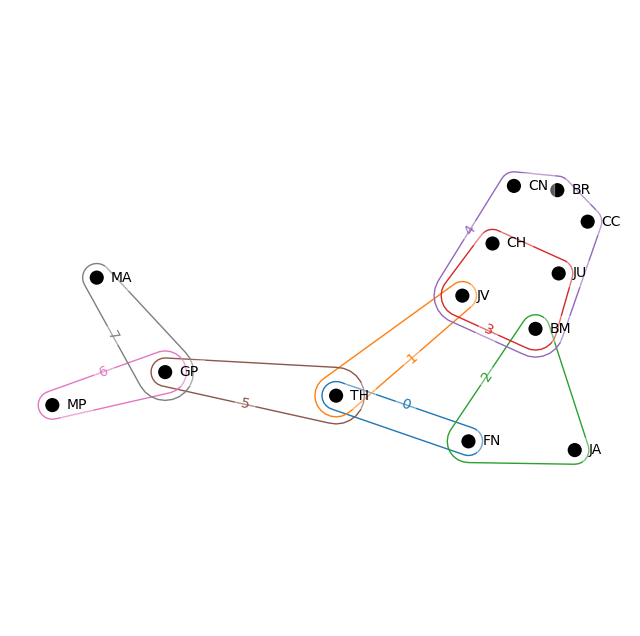

In [4]:
hnx.drawing.draw(H)

We can also view the dual of this graph easily, using the `H.dual()` command.

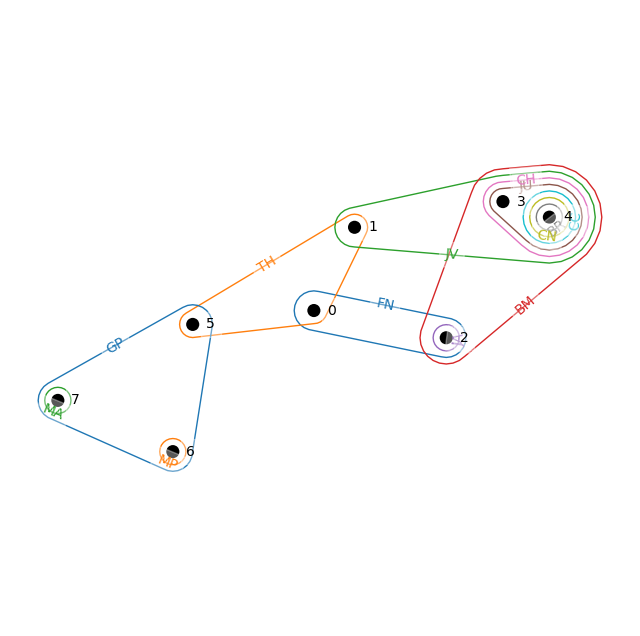

In [5]:
hnx.drawing.draw(H.dual())

## New Visualizations

The **Two-Column Bipartite** visualization is a variation of the traditional bipartite graph, structured in a two-column layout. In this representation, edges are positioned in the left column, while nodes are displayed in the right column. Node vertices are represented as black dots, and hyperedges are depicted using a combination of convex shapes and lines that connect each edge to its corresponding nodes. This layout enhances clarity by visually distinguishing nodes from their associated edges while maintaining the structural relationships within the hypergraph.

The **Incidence/UpSet** visualization represents a hypergraph as an incidence matrix, following the principles of the UpSet approach. This visualization is structured in a row-column layout, where each row corresponds to a node, and each column represents a hyperedge. Nodes are depicted as black dots, while the connections between these dots are represented by lines, indicating the presence of a hyperedge. If a node is associated with only a single hyperedge, no connecting lines are displayed within the corresponding row. This approach provides a clear and structured representation of hypergraph relationships within an incidence matrix framework.


<class 'networkx.utils.decorators.argmap'> compilation 20:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


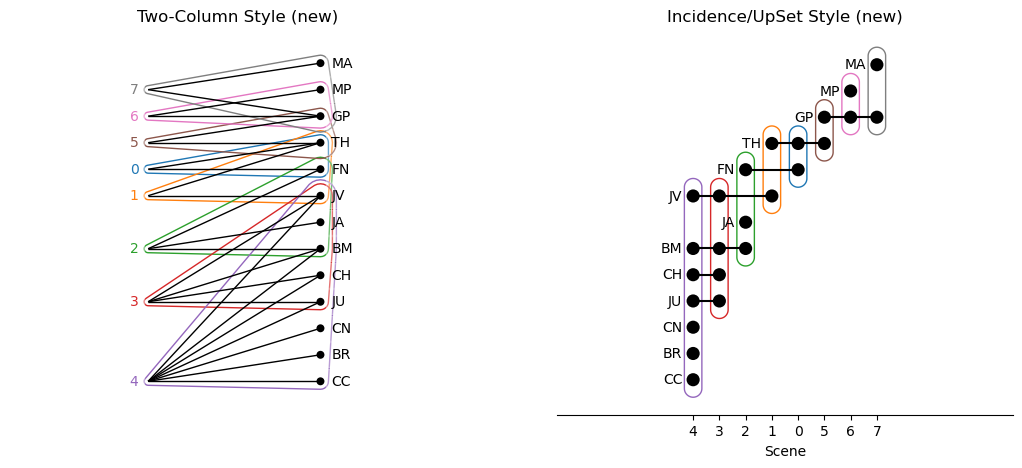

In [6]:
plt.figure(figsize=(20, 5))

plt.subplot(132)
plt.title('Two-Column Style (new)')
hnx.draw_bipartite_using_euler(H)

plt.subplot(133)
plt.title('Incidence/UpSet Style (new)')
hnx.draw_incidence_upset(H)
plt.xlabel('Scene');

# Basic Visualization Parameters
We will now explore some of the basic visualization parameters that are special for hypergraph visualization
* filling in edges
* collapsing vertices and edges
* disabling labels

## Filling in edges
When `fill_edges` are set to True, the face colors of the edges are automatically assigned to the lighter variant of the corresponding edge colors

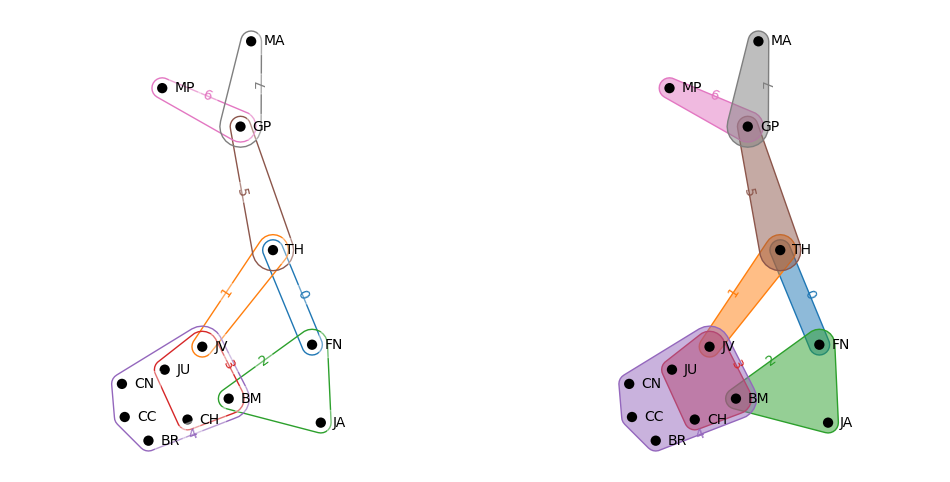

In [7]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
pos = hnx.drawing.draw(H, return_pos=True)

plt.subplot(122)
hnx.drawing.draw(H, pos=pos, fill_edges=True,
     node_label_alpha=0.0, edge_label_alpha=0.0,
)

## Disabling labels
If edge or node labels are a distraction, they can be turned off completely by passing in `with_edge_labels=False` or `with_node_labels=False`

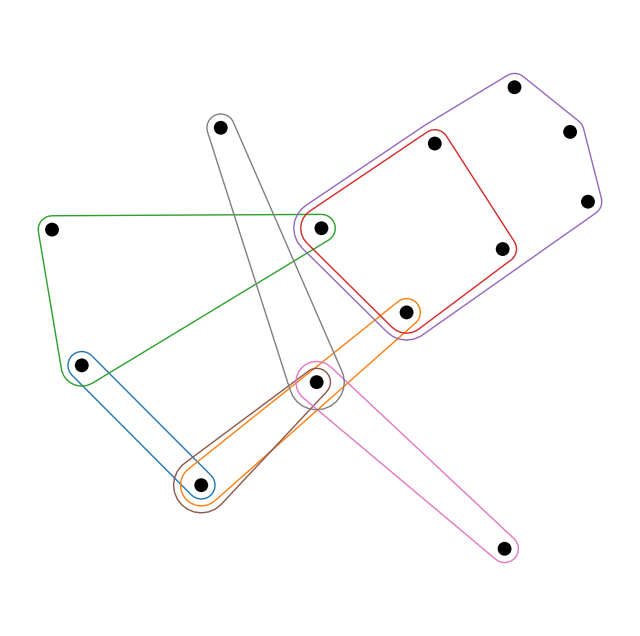

In [9]:
hnx.drawing.draw(H, with_edge_labels=False, with_node_labels=False)